In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
def ShowImage(img, gray):
    plt.axis("off")
    if gray:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    plt.show()

In [3]:
def cv2_show(caption, im):
    cv2.imshow(caption,im)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [4]:
def split_sub_image(img):
    # print(img.shape)
    h, w = img.shape
    w_cutoff = w // 2
    img_left = img[:,:w_cutoff]
    img_right = img[:,w_cutoff:]
    return img_left, img_right 

In [5]:
def hist_img_v0(f):
    m, n = f.shape
    h = [0.0] * 256
    for i in range(m):
        for j in range(n):
            h[f[i, j]]+=1
    return np.array(h, dtype='uint16')

In [6]:
def delete_noise(img):
    mask = np.ones([3, 3], dtype = 'float16') 
    mask = mask/9
    print(mask)
    f = img.copy().astype(np.float16)
    (m,n) = img.shape
    out = np.zeros_like(img, dtype = 'float16')

    for i in range(1,m-1):
        for j in range(1,n-1):
            tmp = 0
            for p in range(3):
                for q in range(3):
                    tmp = tmp + (mask[p,q]*f[i+p-1,j+q-1])
            out[i,j] = tmp   
    return out.astype(np.uint8)

In [7]:
def intermean(hist, t, st, en):
    tot = np.sum(hist[st:en])
    prob = hist/tot
    w0 = np.sum(prob[st:t+1]) + 0.0000001
    #w1 = np.sum(prob[t+1:en])
    w1 = (1 - w0) +  + 0.0000001
    i0 = np.array([i for i in range(st,t+1)])
    i1 = np.array([i for i in range(t+1, en)])
    u0 = np.sum(i0*prob[st:t+1])/w0
    u1 = np.sum(i1*prob[t+1:en])/w1
    if u0 == 0.0:
        thr = u1
    elif u1 == 0.0:
        thr = u0
    else:
        thr = (u0+u1)/2
    return thr.astype(np.uint8)    

In [8]:
def rgb_to_cmyk(img, rgb_scale, cmyk_scale):
    R = img[:, :, 2].astype(np.float16)/rgb_scale
    G = img[:, :, 1].astype(np.float16)/rgb_scale
    B = img[:, :, 0].astype(np.float16)/rgb_scale
    
    C, M, Y = 1 - R, 1 - G, 1 - B
    min_cym = np.minimum.reduce([C, M, Y])
    
    C = (C-min_cym)*cmyk_scale
    M = (M-min_cym)*cmyk_scale
    Y = (Y-min_cym)*cmyk_scale
    K = min_cym*cmyk_scale
    return C.astype(np.uint8),M.astype(np.uint8),Y.astype(np.uint8),K.astype(np.uint8)

In [9]:
img_bgr = cv2.imread('./images/color.png', 1)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

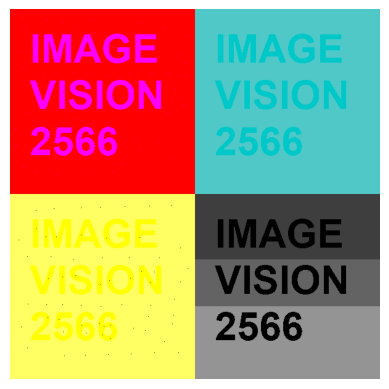

In [10]:
ShowImage(img_rgb, 0)

In [11]:
c, m, y, k = rgb_to_cmyk(img_rgb, 255, 255)

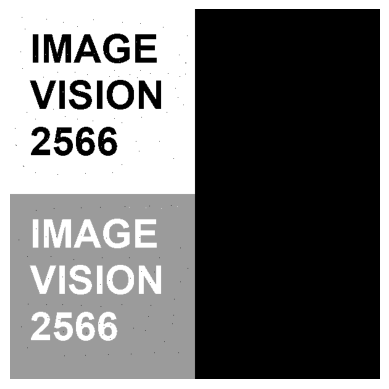

In [12]:
ShowImage(c, 1)

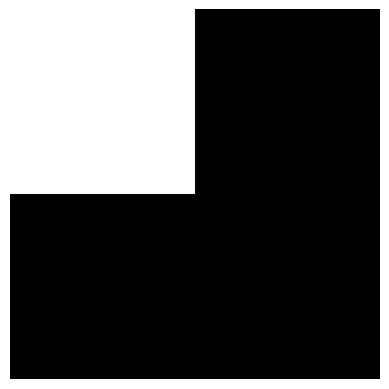

In [13]:
ShowImage(m, 1)

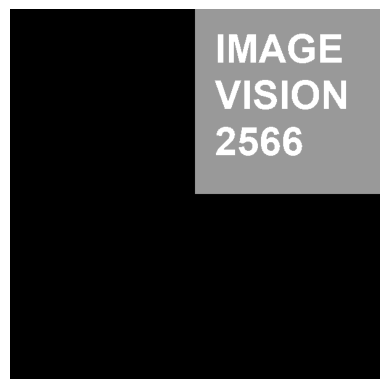

In [14]:
ShowImage(y, 1)

## Split

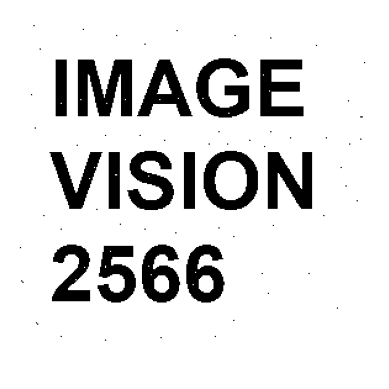

In [15]:
sub1, sub2 = split_sub_image(c)
sub1_1, sub1_2 = split_sub_image((sub1.transpose()))
sub1_1 = sub1_1.transpose()
ShowImage(sub1_1, 1)

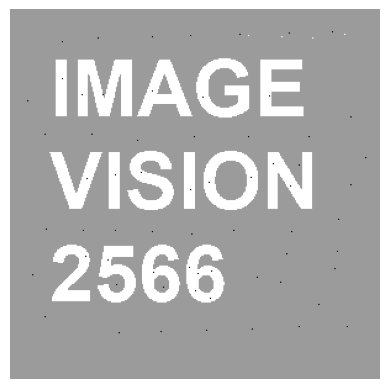

In [16]:
sub1_2 = sub1_2.transpose()
ShowImage(sub1_2, 1)

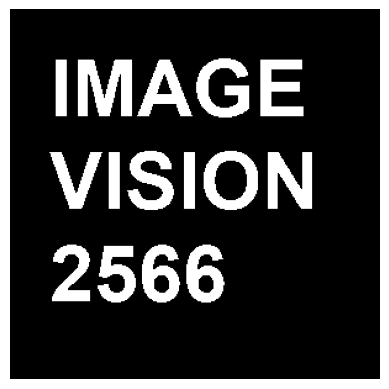

In [17]:
sub1, sub2 = split_sub_image(y)
sub2_1, sub = split_sub_image((sub2.transpose()))
sub2_1 = sub2_1.transpose()
ShowImage(sub2_1, 1)

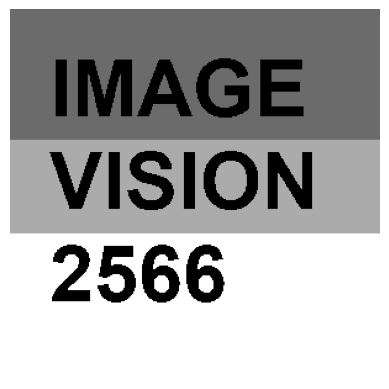

In [18]:
sub1, sub2 = split_sub_image(img_rgb[:, :, 1])
sub, sub2_2 = split_sub_image((sub2.transpose()))
sub2_2 = sub2_2.transpose()
ShowImage(sub2_2, 1)

#### result sub1_1

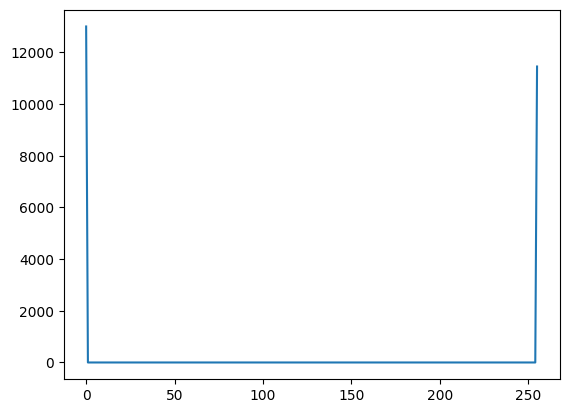

In [19]:
hist = hist_img_v0(sub1_1)
plt.plot(hist)
# ShowImage(sub1_1, 1)

[[0.1111 0.1111 0.1111]
 [0.1111 0.1111 0.1111]
 [0.1111 0.1111 0.1111]]


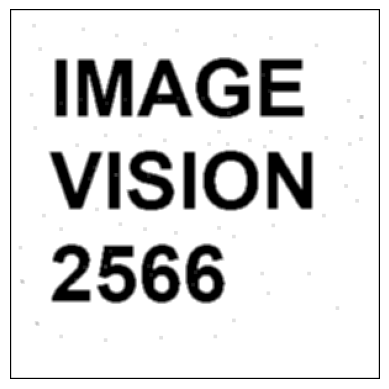

In [20]:
df = delete_noise(sub1_1)
ShowImage(df, 1)

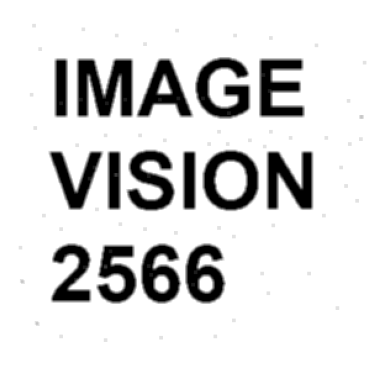

In [21]:
df[0, :] = 255
df[-1, :] = 255
df[:, 0] = 255
df[:, -1] = 255
ShowImage(df, 1)

In [22]:
hist = hist_img_v0(df)
tol = 1
st, en = 0, 256
for t in range(1):
    flag = True
    T = []
    #t0 = random.randint(st, en)
    t0 = int((st+en)*0.5)
    T.append(t0)
    while(flag):
        t1 = intermean(hist[st:en], t0, st, en)
        T.append(t1)
        #print(t0, t1)
        if abs(t1-t0) < tol :
            flag = False
        else:
            t0 = t1
    thr = T[-1]
    en = thr+1
    print(T, thr)

[128, 125, 125] 125


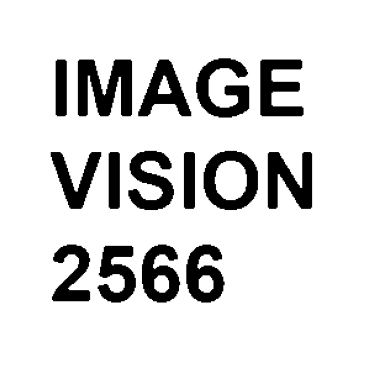

In [23]:
result_sub1_1 = np.zeros_like(sub1_1)
# result_sub2_1[sub2_1 > 150] = 0
result_sub1_1[df > thr] = 255
ShowImage(result_sub1_1, 1)

#### result sub1_2

[[0.1111 0.1111 0.1111]
 [0.1111 0.1111 0.1111]
 [0.1111 0.1111 0.1111]]


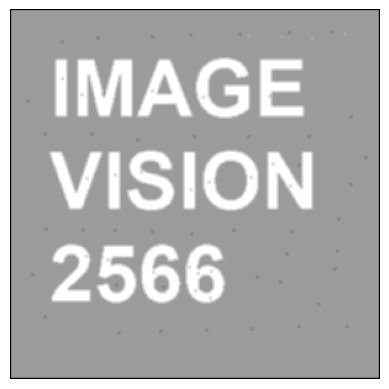

In [24]:
df = delete_noise(sub1_2)
ShowImage(df, 1)

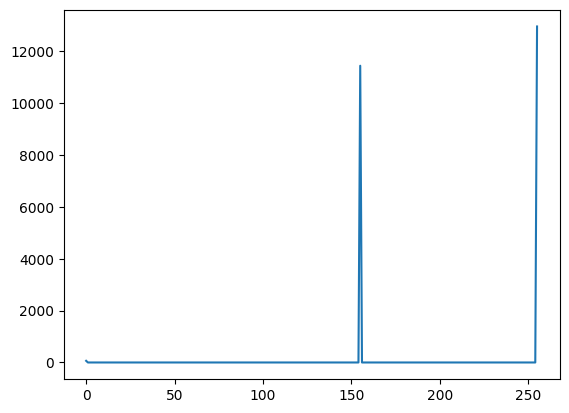

In [25]:
hist = hist_img_v0(sub1_2)
plt.plot(hist)

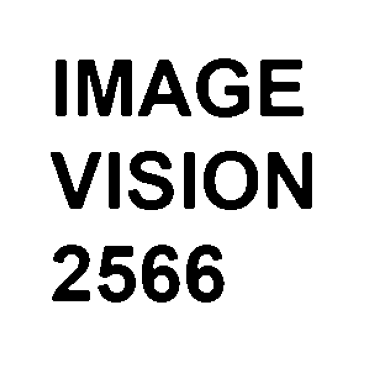

In [26]:
result_sub1_2 = np.zeros_like(sub1_2)
# result_sub2_1[sub2_1 > 150] = 0
result_sub1_2[df <= 200] = 255
ShowImage(result_sub1_2, 1)

#### result sub 2_1

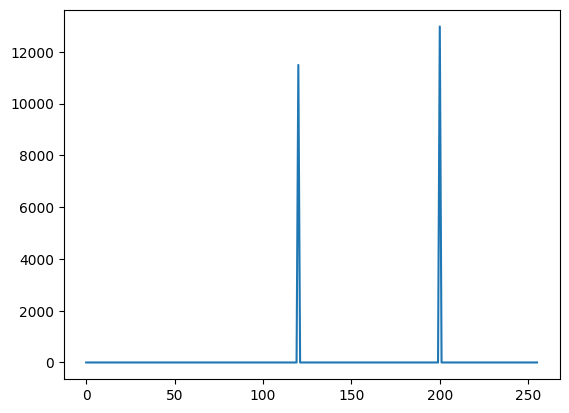

In [27]:
hist = hist_img_v0(sub2_1)
plt.plot(hist)

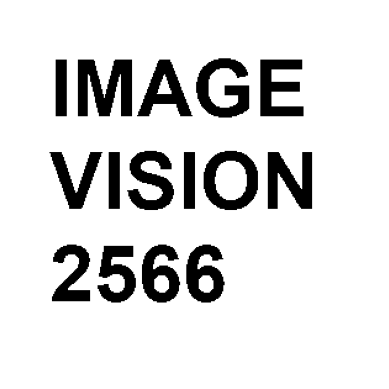

In [28]:
result_sub2_1 = np.zeros_like(sub2_1)
# result_sub2_1[sub2_1 > 150] = 0
result_sub2_1[sub2_1 <= 150] = 255
ShowImage(result_sub2_1, 1)

#### result sub2_2

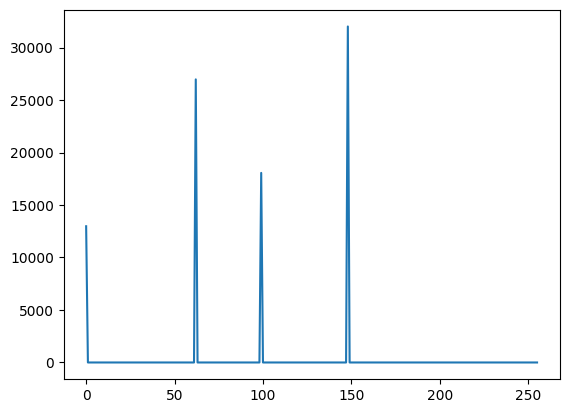

In [29]:
hist = hist_img_v0(sub2_2)
plt.plot(hist)

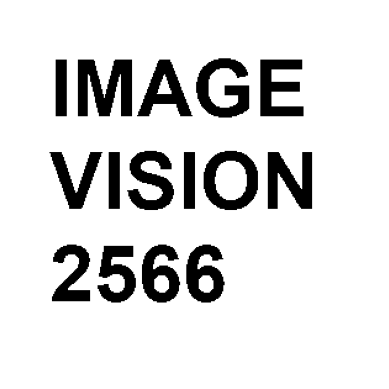

In [30]:
result_sub2_2 = np.zeros_like(sub2_2)
result_sub2_2[sub2_2 > 50] = 255
ShowImage(result_sub2_2, 1)

## Merge

In [31]:
final_result = np.zeros_like(c, dtype='uint8')
h, w = c.shape
wc, hc = w // 2, h // 2
final_result[:hc,:wc] = result_sub1_1
final_result[hc:,:wc] = result_sub1_2
final_result[:hc,wc:] = result_sub2_1
final_result[hc:,wc:] = result_sub2_2

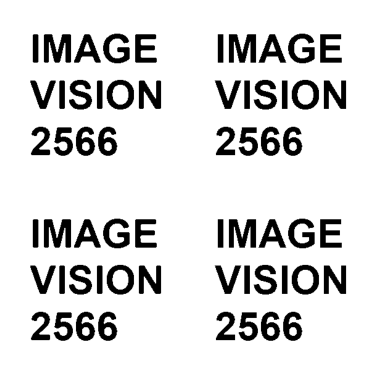

In [32]:
# ShowImage(final_result, 1)
plt.axis('off')
plt.imshow(final_result, cmap='gray')
plt.savefig('./outs/hw4_CMYK.png')